In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

2024-05-24 19:38:54.298159: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [3]:
X = digits['data']
y = digits['target']
print(f'X.shape: {X.shape}')
print(f'y.shape: {y.shape}')

X.shape: (1797, 64)
y.shape: (1797,)


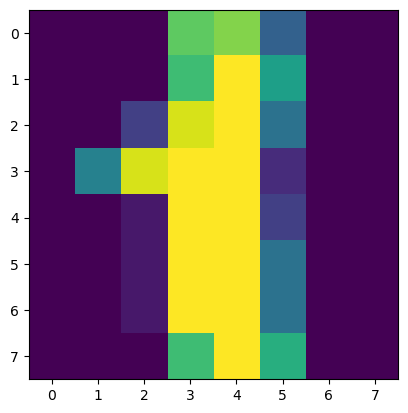

In [4]:
plt.imshow(X[1].reshape(8, 8))

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
X_train = X_train.T
X_test = X_test.T
y_train = tf.keras.utils.to_categorical(y_train).T
print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (64, 1203)
X_test.shape: (64, 594)
y_train.shape: (10, 1203)
y_test.shape: (594,)


In [8]:
def initialize_parameters(layer_dims):
    params = {}
    for i in range(1, len(layer_dims)):
        params[f'W{i}'] = tf.Variable(tf.random.normal(shape=(layer_dims[i], layer_dims[i-1])) * tf.sqrt(2/layer_dims[i-1]))
        params[f'b{i}'] = tf.Variable(tf.zeros(shape=(layer_dims[i], 1)))
    
    return params

In [9]:
def forward_propagation(X, params):

    l = len(params)//2
    A = X
    for i in range(1, l):
        Z = params[f'W{i}'] @ A + params[f'b{i}']
        A = tf.nn.relu(Z)

    Z = params[f'W{l}'] @ A + params[f'b{l}']
    A = tf.nn.softmax(Z)
        
    return A

In [10]:
def compute_cost(y, y_hat):
    loss = tf.keras.losses.categorical_crossentropy(y, y_hat)
    return tf.reduce_mean(loss)

In [11]:
def gradiant_descent(params, grads, learning_rate):
    for i in params.keys():
        params[i].assign_sub(learning_rate * grads[i])
    return params

In [12]:
def learning_rate_decay(learning_rate, epoch_num, decay_rate=1, time_interval=1000):
    learning_rate /= 1 + decay_rate * epoch_num/time_interval
    return learning_rate

In [13]:
def nn_model(X, y, layer_dims, epochs, learning_rate, decay_rate=1, print_cost=False):
    params = initialize_parameters(layer_dims)
    for epoch in range(epochs):            
        with tf.GradientTape() as tape:
            y_hat = forward_propagation(X, params)
            cost = compute_cost(y, y_hat)

            if epoch % 100 == 0 and print_cost:
                print(f'Epoch:{epoch}, Cost: {cost:0.2f}')
        
        grads = tape.gradient(cost, params)
        decayed_learning_rate = learning_rate_decay(learning_rate, epoch, decay_rate)
        params = gradiant_descent(params, grads, decayed_learning_rate)
    return params

In [14]:
LEARNING_RATE = 0.02
EPOCHS = 2500
LAYER_DIMS = [
    X_train.shape[0],       # input size
    64,                     # hidden_layer_1
    32,                     # hidden_layer_2
    y_train.shape[0]        # output neurons
]
params = nn_model(X_train, y_train, LAYER_DIMS, EPOCHS, LEARNING_RATE, decay_rate=1.5, print_cost=True)

2024-05-24 19:38:58.913808: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch:0, Cost: 846.06
Epoch:100, Cost: 589.87
Epoch:200, Cost: 581.85
Epoch:300, Cost: 579.65
Epoch:400, Cost: 577.83
Epoch:500, Cost: 577.42
Epoch:600, Cost: 577.20
Epoch:700, Cost: 577.06
Epoch:800, Cost: 576.90
Epoch:900, Cost: 576.80
Epoch:1000, Cost: 576.74
Epoch:1100, Cost: 576.71
Epoch:1200, Cost: 576.66
Epoch:1300, Cost: 576.64
Epoch:1400, Cost: 576.62
Epoch:1500, Cost: 576.60
Epoch:1600, Cost: 576.59
Epoch:1700, Cost: 576.57
Epoch:1800, Cost: 576.56
Epoch:1900, Cost: 576.56
Epoch:2000, Cost: 576.55
Epoch:2100, Cost: 576.54
Epoch:2200, Cost: 576.53
Epoch:2300, Cost: 576.53
Epoch:2400, Cost: 576.52


In [15]:
def predict(X, params):
    y_hat = forward_propagation(X, params)
    y_pred = np.argmax(y_hat, axis=0)
    
    return y_pred

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       0.96      1.00      0.98        55
           2       0.98      1.00      0.99        52
           3       0.98      0.96      0.97        56
           4       1.00      1.00      1.00        64
           5       0.97      0.99      0.98        73
           6       0.98      1.00      0.99        57
           7       1.00      0.98      0.99        62
           8       0.98      0.94      0.96        52
           9       0.99      0.97      0.98        68

    accuracy                           0.98       594
   macro avg       0.98      0.98      0.98       594
weighted avg       0.98      0.98      0.98       594



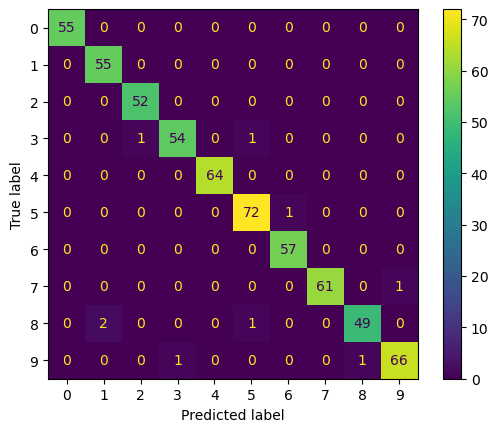

In [16]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

y_pred = predict(X_test, params)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

In [17]:
y_pred_train = predict(X_train, params)
accuracy_score(y_train.argmax(axis=0), y_pred_train)

1.0

In [18]:
accuracy_score(y_test, y_pred)

0.9848484848484849

In [19]:
def find_closest_factors(number):
    a = int(np.sqrt(number))
    for i in range(a, 0, -1):
        if number % i == 0:
            return i, number // i

In [20]:
err = np.sum(y_test != y_pred)
a, b = find_closest_factors(err)
print(f'{err} = {a} * {b}')

9 = 3 * 3


In [21]:
true_lable = y_test[y_test != y_pred]
predicted_lable = y_pred[y_test != y_pred]

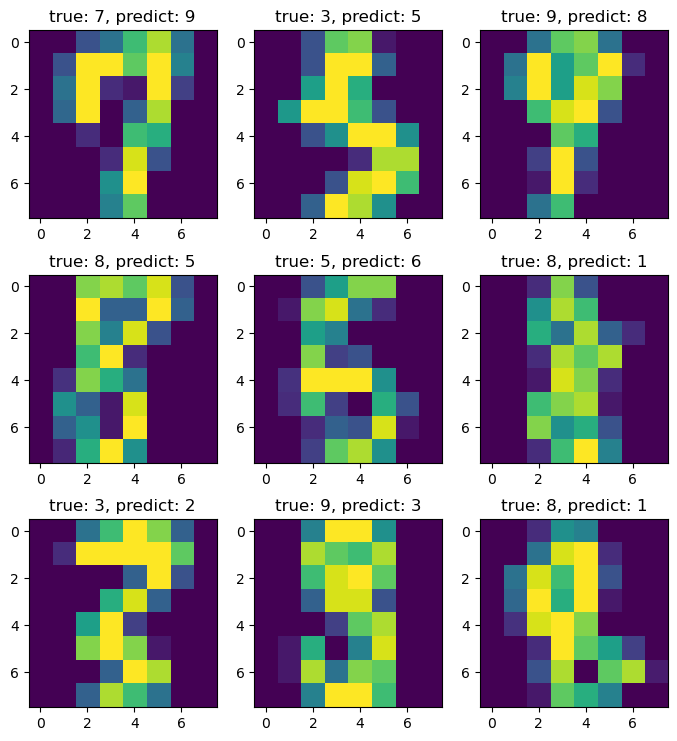

In [22]:
fig, axs = plt.subplots(a, b, figsize=(b*2.75, a*3))
for i, ax in enumerate(axs.flat):
    ax.imshow(X_test[:, y_test != y_pred][:, i].reshape(8, 8))
    ax.set_title(f'true: {true_lable[i]}, predict: {predicted_lable[i]}')